This notebook creates a set of 16 naive templates, plots the matched photometry, trains the templates, and then makes plots of the results and the training process.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, copy
from scipy.interpolate import interp1d

from modules.galaxyphoto import get_bandpass_dict, Sed
from modules.photomatching import create_training_sets
from modules.training import new_naive_templates, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/training_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [5]:
def log_norm(x,mode,sigma):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    return f1(x)/f1(5000)

N = 16
n = 6
modes  = np.concatenate((np.linspace(5500,4600,n,endpoint=False),np.linspace(4600,1000,N-n)))
sigmas = np.concatenate((np.linspace(0.35,0.56,n,endpoint=False),np.linspace(0.56, 0.9,N-n)))

# save the templates as Seds
x = np.arange(10,15000,100,dtype=float)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i])
    naive_templates["N"+str(N)+"-"+str(i+1)] = template
    
del N,n,modes,sigmas,x,i,template

Create training sets and plot them

In [6]:
%%time
training_sets = create_training_sets(galaxies, naive_templates, bandpass_dict)

CPU times: user 9.71 s, sys: 804 ms, total: 10.5 s
Wall time: 1min 30s


Number of galaxies in each training set:
[11683, 7783, 6320, 5481, 5256, 5176, 6629, 7317, 5777, 3661, 1927, 1544, 2226, 2970, 3566, 4664]


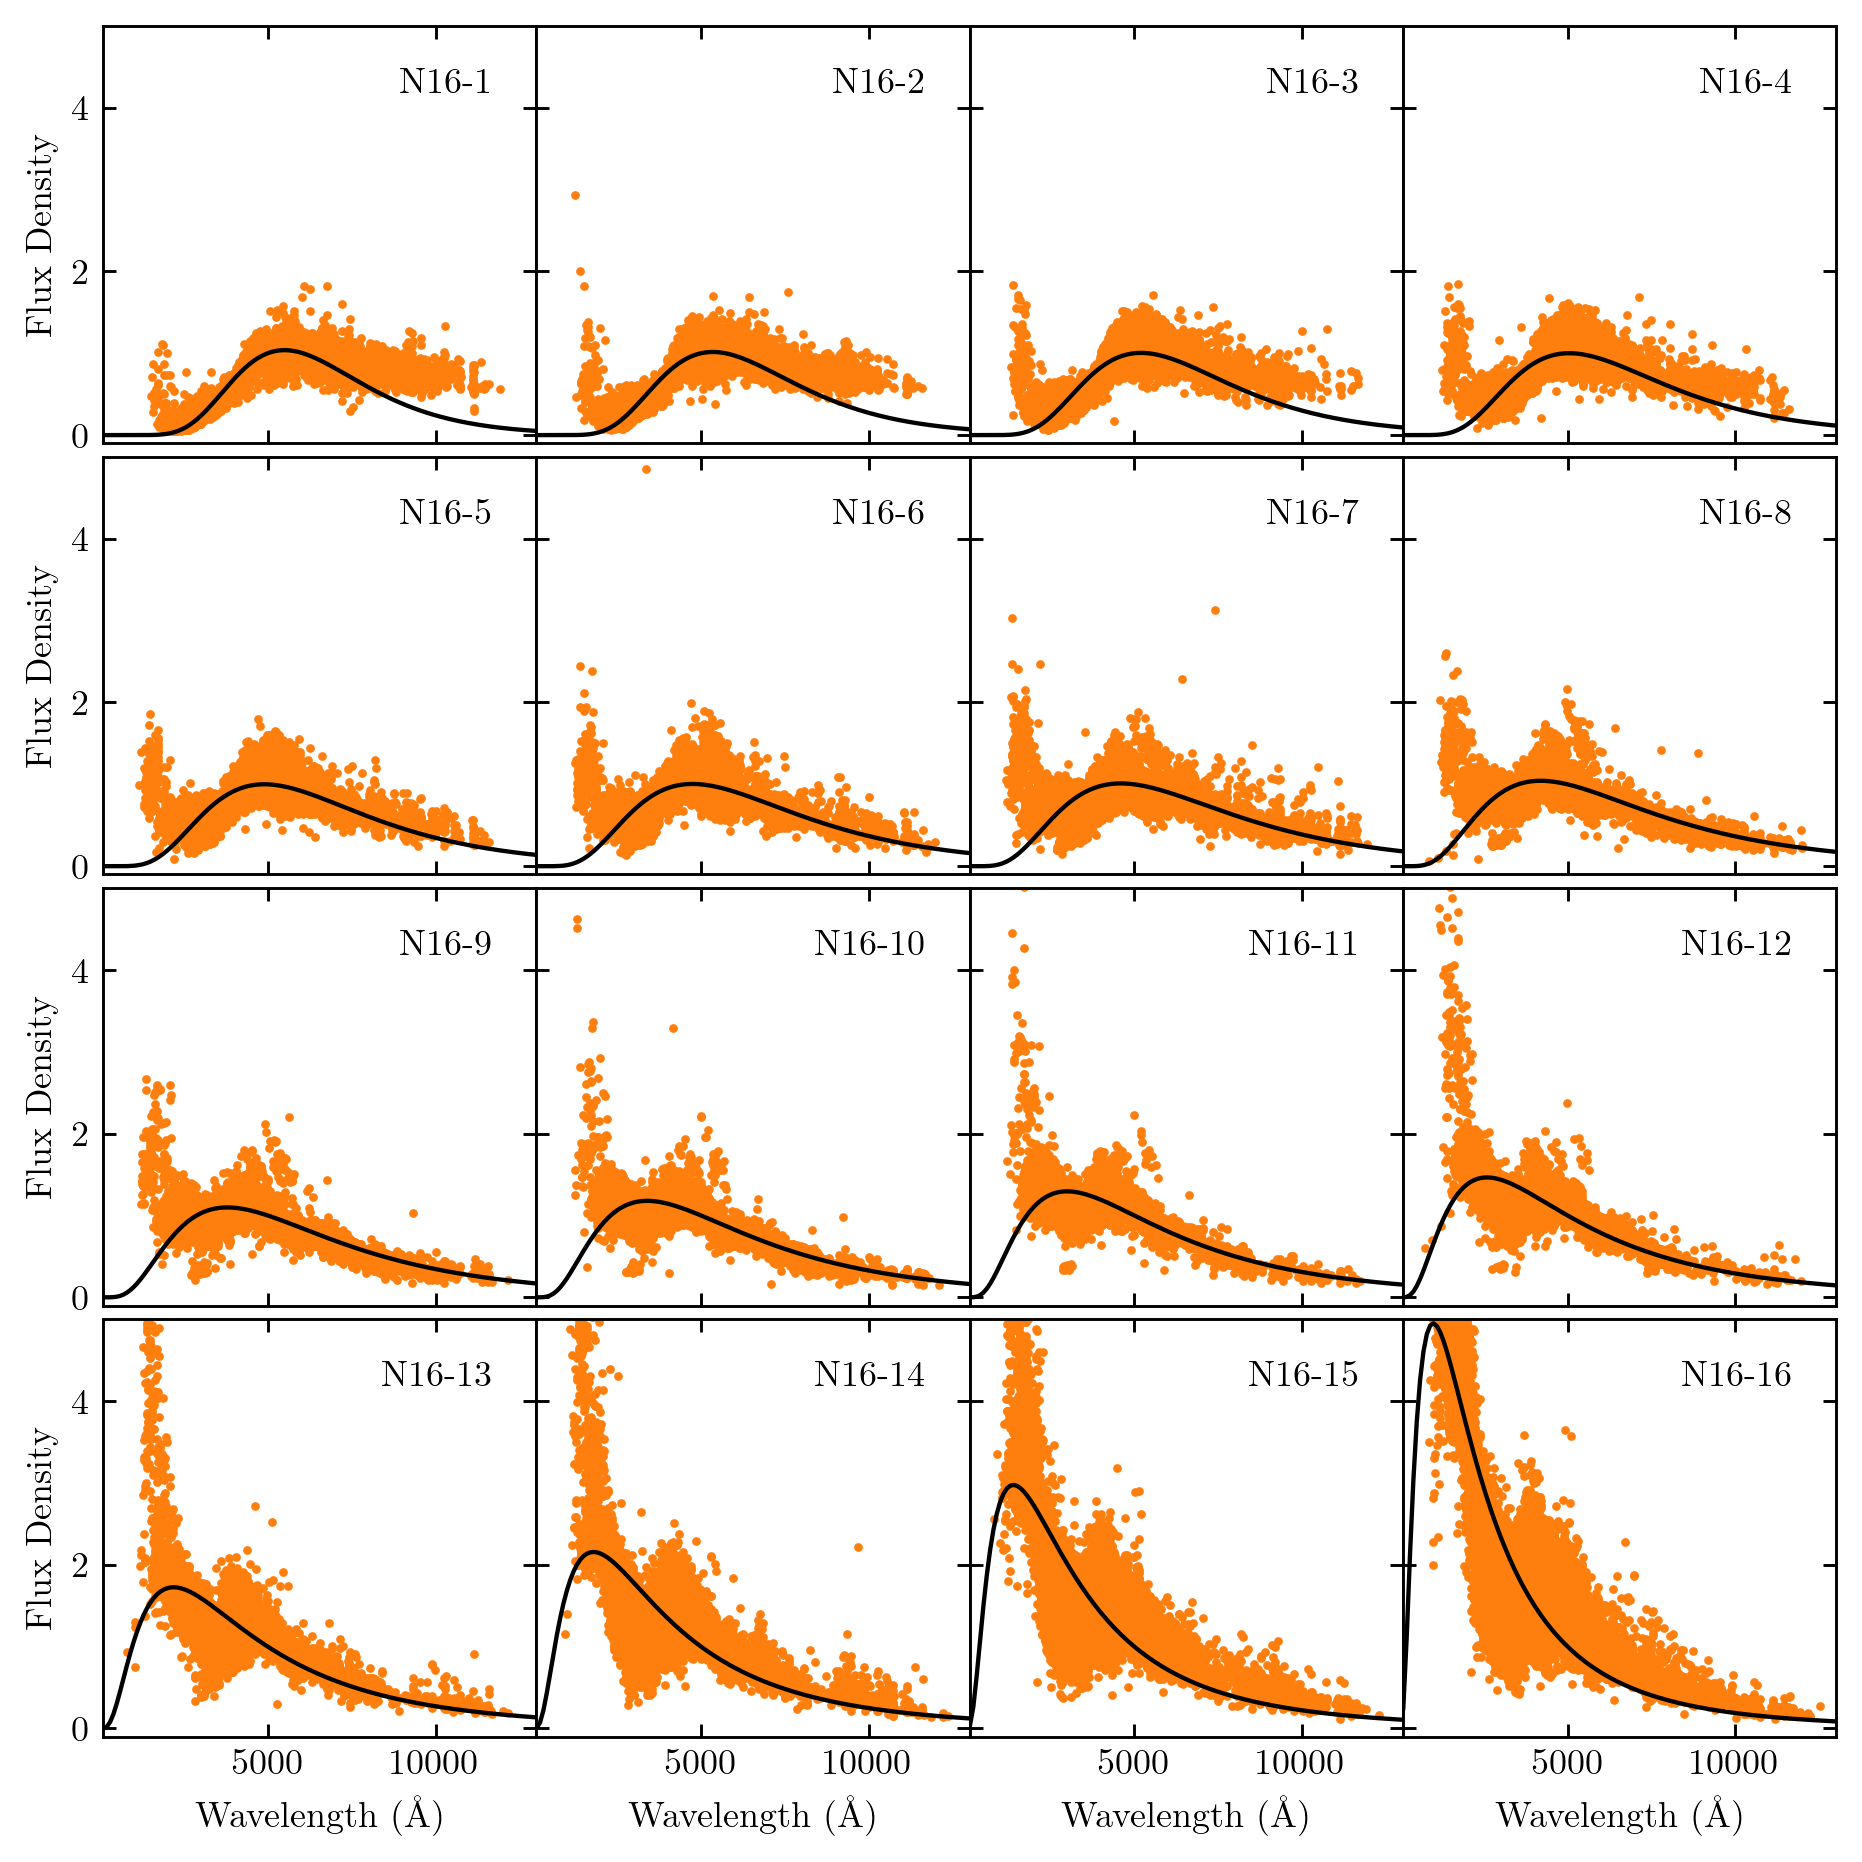

In [8]:
ncols = 4
nrows = 4
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols))

print("Number of galaxies in each training set:")
print([len(i) for i in training_sets.values()])

for key,ax in zip(training_sets.keys(),axes.flatten()):
    
    tset = training_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    template = naive_templates[key]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")
    
    ax.set_xlim(100,13000)
    ax.set_ylim(-0.1,5)

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

Now train the templates.

In [9]:
%%time
trained_templates, history = train_templates(galaxies, naive_templates, bandpass_dict, w=0.5, dmse_stop=0.05)

Columns: Template, number of perturbations, initial/final wMSE
Round 1
N16-1     4       68.8       29.2
N16-2     3       92.3       47.9
N16-3     3       98.0       61.7
N16-4     2       89.1       63.9
N16-5     2       71.7       52.1
N16-6     2       74.7       53.4
N16-7     3       84.9       58.3
N16-8     3       56.9       33.2
N16-9     2       59.9       33.7
N16-10    2       76.5       41.2
N16-11    2      123.1       74.1
N16-12    2      190.9      109.7
N16-13    3      270.4      138.4
N16-14    3      502.7      259.6
N16-15    2      985.9      578.2
N16-16    2     1567.6      920.0
Round 2
N16-1     2       32.2       27.2
N16-2     2       41.4       35.1
N16-3     2       46.5       40.6
N16-4     2       42.4       37.2
N16-5     2       45.2       39.5
N16-6     2       30.4       27.8
N16-7     2       31.8       27.8
N16-8     2       20.4       18.6
N16-9     2       16.3       15.3
N16-10    2       21.4       20.0
N16-11    2       36.1       32.8
N16

Generate the training sets for these final templates, for plotting purposes

In [10]:
final_sets = create_training_sets(galaxies, trained_templates, bandpass_dict)

Save the results!

In [14]:
"""for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = trained_templates[template].wavelen
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10.2f}{1:<10.4f}\n".format(x[i],y[i]))
    file.close()
    
f = open("templates/N16_training_history.pkl","wb")
pickle.dump(history,f)
f.close()""";

OR load the results if you didn't just run the training.

In [6]:
"""trained_templates = dict()
for template in naive_templates:
    x,y = np.loadtxt('templates/'+template+'.sed',unpack=True)
    trained_templates[template] = Sed(x,y)
    
final_sets = create_training_sets(trained_templates, galaxies, bandpass_dict)

with open('templates/N16_training_history.pkl', 'rb') as input:
    history = pickle.load(input)""";

Plot the trained templates

Number of galaxies in each training set:
[5271, 4875, 5599, 5241, 4813, 5786, 5009, 6405, 6227, 6138, 5410, 5452, 3883, 5895, 4170, 1806]


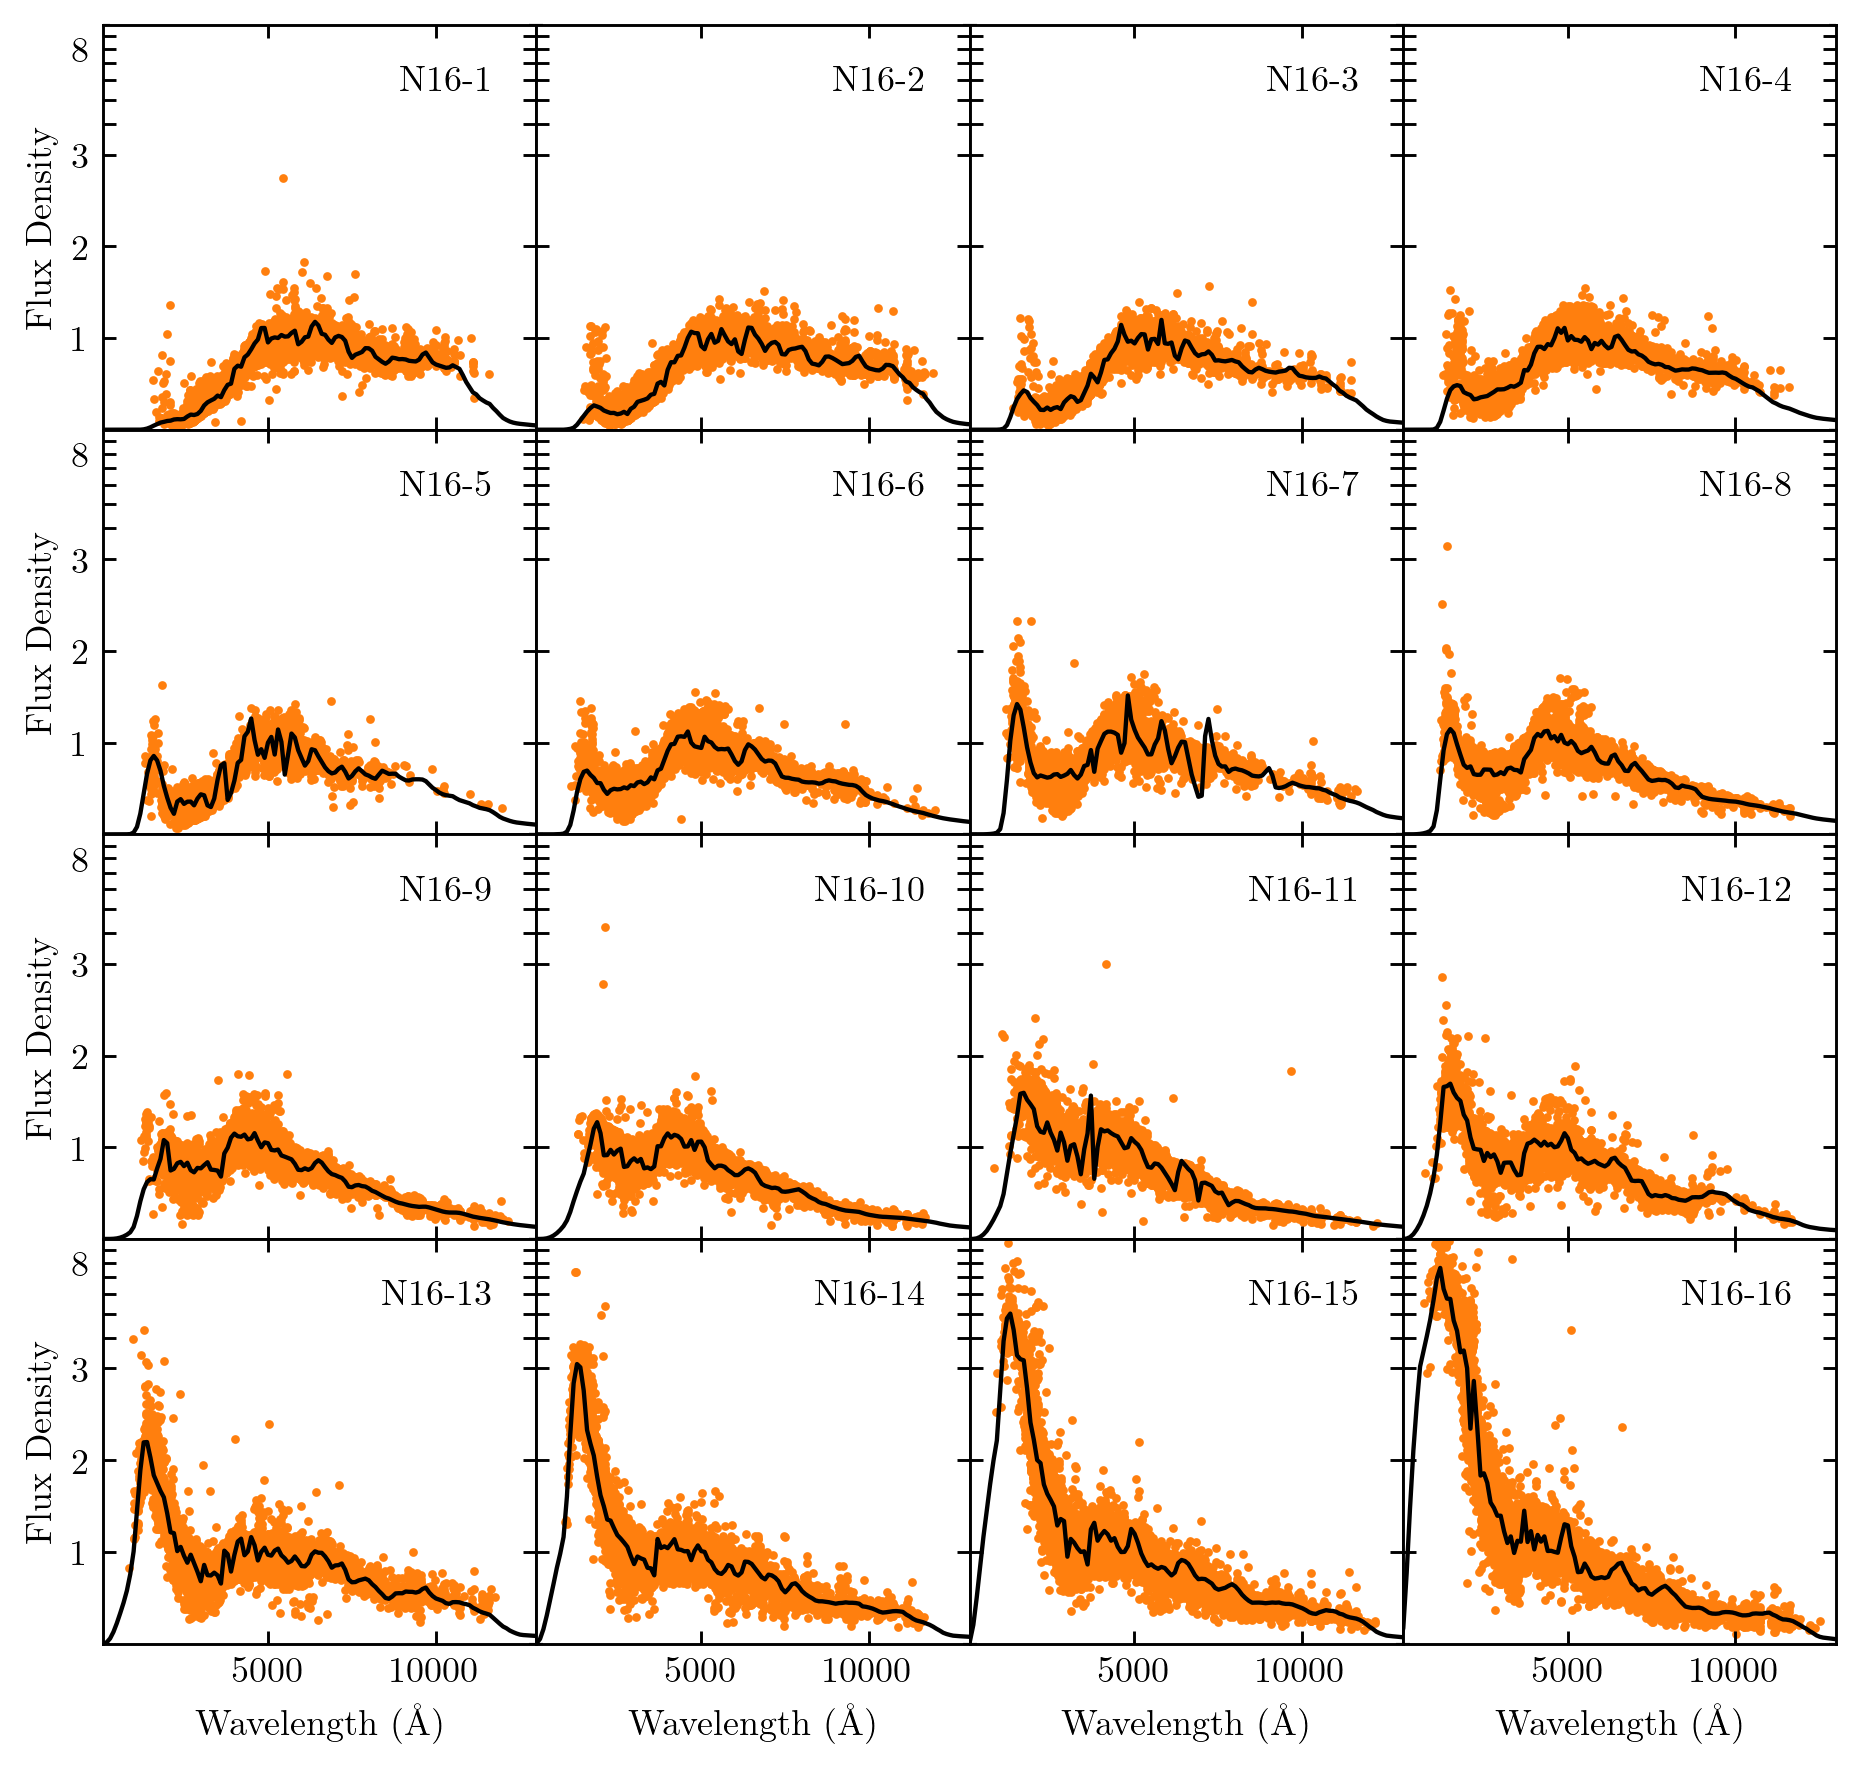

In [12]:
ncols = 4
nrows = 4
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='row',figsize=(twocol,twocol*nrows/ncols*0.95))

print("Number of galaxies in each training set:")
print([len(i) for i in final_sets.values()])

for key,ax in zip(final_sets.keys(),axes.flatten()):
    
    tset = final_sets[key]
    wavelen = [w for galaxy in tset for w in galaxy.wavelen]
    fluxes = [f for galaxy in tset for f in galaxy.fluxes]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    del tset, wavelen, fluxes
    
    template = trained_templates[key]
    ax.plot(template.wavelen, template.flambda, c="k")
    
    ax.text(0.9,0.9,key,transform=ax.transAxes,ha="right",va="top")

for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_xlim(100,13000)
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    ax.set_yscale('symlog',linthreshy=3)
    ax.set_ylim(0,10)
    ax.set_yticks([1,2,3,4,5,6,7,8,9])
    ax.set_yticklabels([1,2,3,'','','','',8,''])
    
fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/N16_trained.png')

Plots of the training history

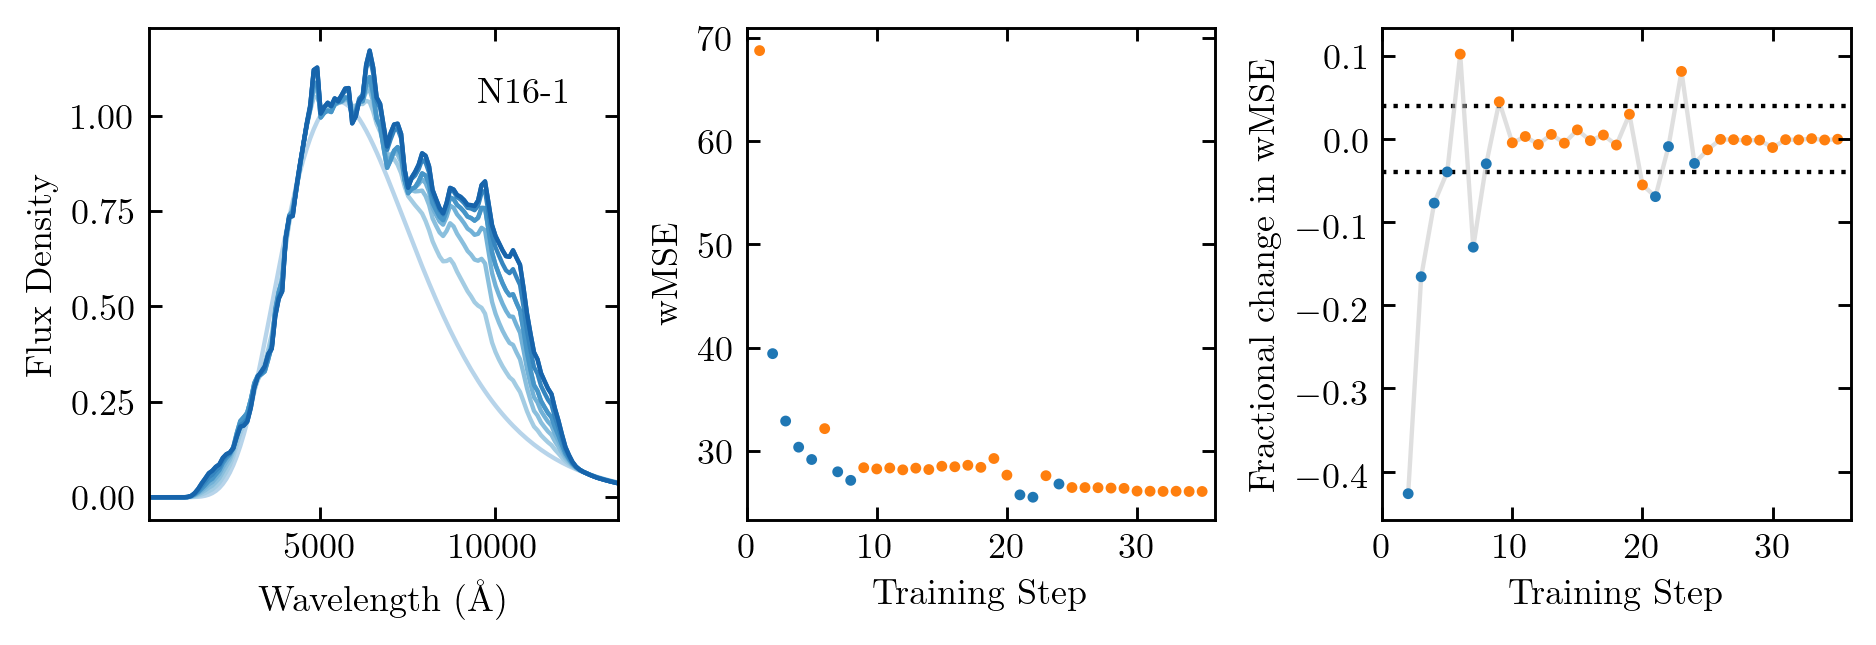

In [13]:
template = "N16-1"

seds = []
mse = []
colors = []

for Round in history[template].values():
    seds.extend(Round[0])
    mse.extend(Round[1])
    colors.append('C1')
    for i in range(len(Round[0])-1):
        colors.append('C0')

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(twocol,twocol/3),constrained_layout=True)

seds = seds[:9]
color_idx = np.linspace(0.3,0.8,len(seds))
for i,sed in enumerate(seds):
    ax1.plot(sed.wavelen, sed.flambda, c=plt.cm.Blues(color_idx[i]))
    
ax1.text(0.9,0.9,template,transform=ax1.transAxes,ha="right",va="top")

x = np.arange(1,len(mse)+1)
ax2.scatter(x, mse, c=colors)

x = np.arange(1,len(mse)) + 1
dmse = [(mse[i+1]-mse[i])/mse[i] for i in range(len(x))]
ax3.scatter(x, dmse, color=colors[1:])
ax3.plot(x, dmse, c='silver',zorder=0,alpha=0.5)
ax3.hlines(0.04,0,max(x)+1,color='k',zorder=0,ls=':')
ax3.hlines(-0.04,0,max(x)+1,color='k',zorder=0,ls=':')

ax1.set_xlim(100,13500)
ax1.set_xlabel("Wavelength (\AA)")
ax1.set_ylabel("Flux Density")

ax2.set_xlim(0,max(x)+1)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('wMSE')

ax3.set_xlim(0,max(x)+1)
ax3.set_xlabel('Training Step')
ax3.set_ylabel('Fractional change in wMSE')

plt.show()